In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.svm import OneClassSVM
import pandas as pd
import torch
from glob import glob

from py.Dataset import Dataset
from py.FileUtils import load
from py.PlotUtils import plot_roc_curve, get_percentiles
from py.PyTorchData import get_log, create_dataloader, model_output_to_image
from py.Labels import LABELS
from py.Autoencoder2 import Autoencoder
from py.ImageUtils import display_images
from torchinfo import summary

DIR = '/home/kleinsteuber/vscode/ResizedSessions256_NoBackup' # dataset directory
SESSION = "beaver_01"
TRAIN_NAME = "ae2_beaver_01_1"

ds = Dataset(DIR)
session = ds.create_session(SESSION)

/home/kleinsteuber/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found 3 sessions
Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions256_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.


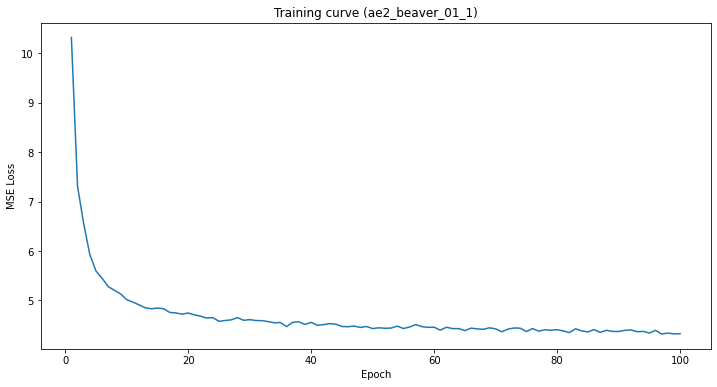

In [2]:
its, losses = get_log(TRAIN_NAME, display=True)

## Output visualization

In [3]:
model_path = sorted(glob(f"./ae_train_NoBackup/{TRAIN_NAME}/model_*.pth"))[-1]
model = Autoencoder()
model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
model.eval()
summary(model, input_size=(32, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [32, 3, 256, 256]         --
├─Sequential: 1-1                        [32, 32, 4, 4]            --
│    └─Dropout: 2-1                      [32, 3, 256, 256]         --
│    └─Conv2d: 2-2                       [32, 32, 128, 128]        4,736
│    └─ReLU: 2-3                         [32, 32, 128, 128]        --
│    └─Dropout: 2-4                      [32, 32, 128, 128]        --
│    └─Conv2d: 2-5                       [32, 64, 64, 64]          51,264
│    └─ReLU: 2-6                         [32, 64, 64, 64]          --
│    └─Dropout: 2-7                      [32, 64, 64, 64]          --
│    └─Conv2d: 2-8                       [32, 64, 32, 32]          36,928
│    └─ReLU: 2-9                         [32, 64, 32, 32]          --
│    └─Dropout: 2-10                     [32, 64, 32, 32]          --
│    └─Conv2d: 2-11                      [32, 64, 16, 16]          36,928


In [6]:
summary(model.encoder, input_size=(32, 3, 256, 256))
#summary(model.decoder, input_size=(32, 32, 4, 4))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 32, 4, 4]            --
├─Dropout: 1-1                           [32, 3, 256, 256]         --
├─Conv2d: 1-2                            [32, 32, 128, 128]        4,736
├─ReLU: 1-3                              [32, 32, 128, 128]        --
├─Dropout: 1-4                           [32, 32, 128, 128]        --
├─Conv2d: 1-5                            [32, 64, 64, 64]          51,264
├─ReLU: 1-6                              [32, 64, 64, 64]          --
├─Dropout: 1-7                           [32, 64, 64, 64]          --
├─Conv2d: 1-8                            [32, 64, 32, 32]          36,928
├─ReLU: 1-9                              [32, 64, 32, 32]          --
├─Dropout: 1-10                          [32, 64, 32, 32]          --
├─Conv2d: 1-11                           [32, 64, 16, 16]          36,928
├─ReLU: 1-12                             [32, 64, 16, 16]          --


In [7]:
only_anomalous = False

def labeler(filename: str) -> int:
    is_normal = (int(filename[-9:-4]) in LABELS[session.name]["normal"])
    return 0 if is_normal else 1

def is_labeled(filename: str) -> bool:
    img_nr = int(filename[-9:-4])
    return (img_nr <= LABELS[session.name]["max"]) and (img_nr not in LABELS[session.name]["not_annotated"]) and (not only_anomalous or img_nr in LABELS[session.name]["anomalous"])

test_dl = create_dataloader(session.get_motion_folder(), shuffle=False, labeler=labeler, filter=is_labeled, skip_transforms=True)

695 files found


In [8]:
features, labels = next(iter(test_dl))
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")
input_imgs = model_output_to_image(features).detach()
output_imgs = model_output_to_image(model(features)).detach()

Feature batch shape: torch.Size([32, 3, 256, 256])
Labels batch shape: torch.Size([32])


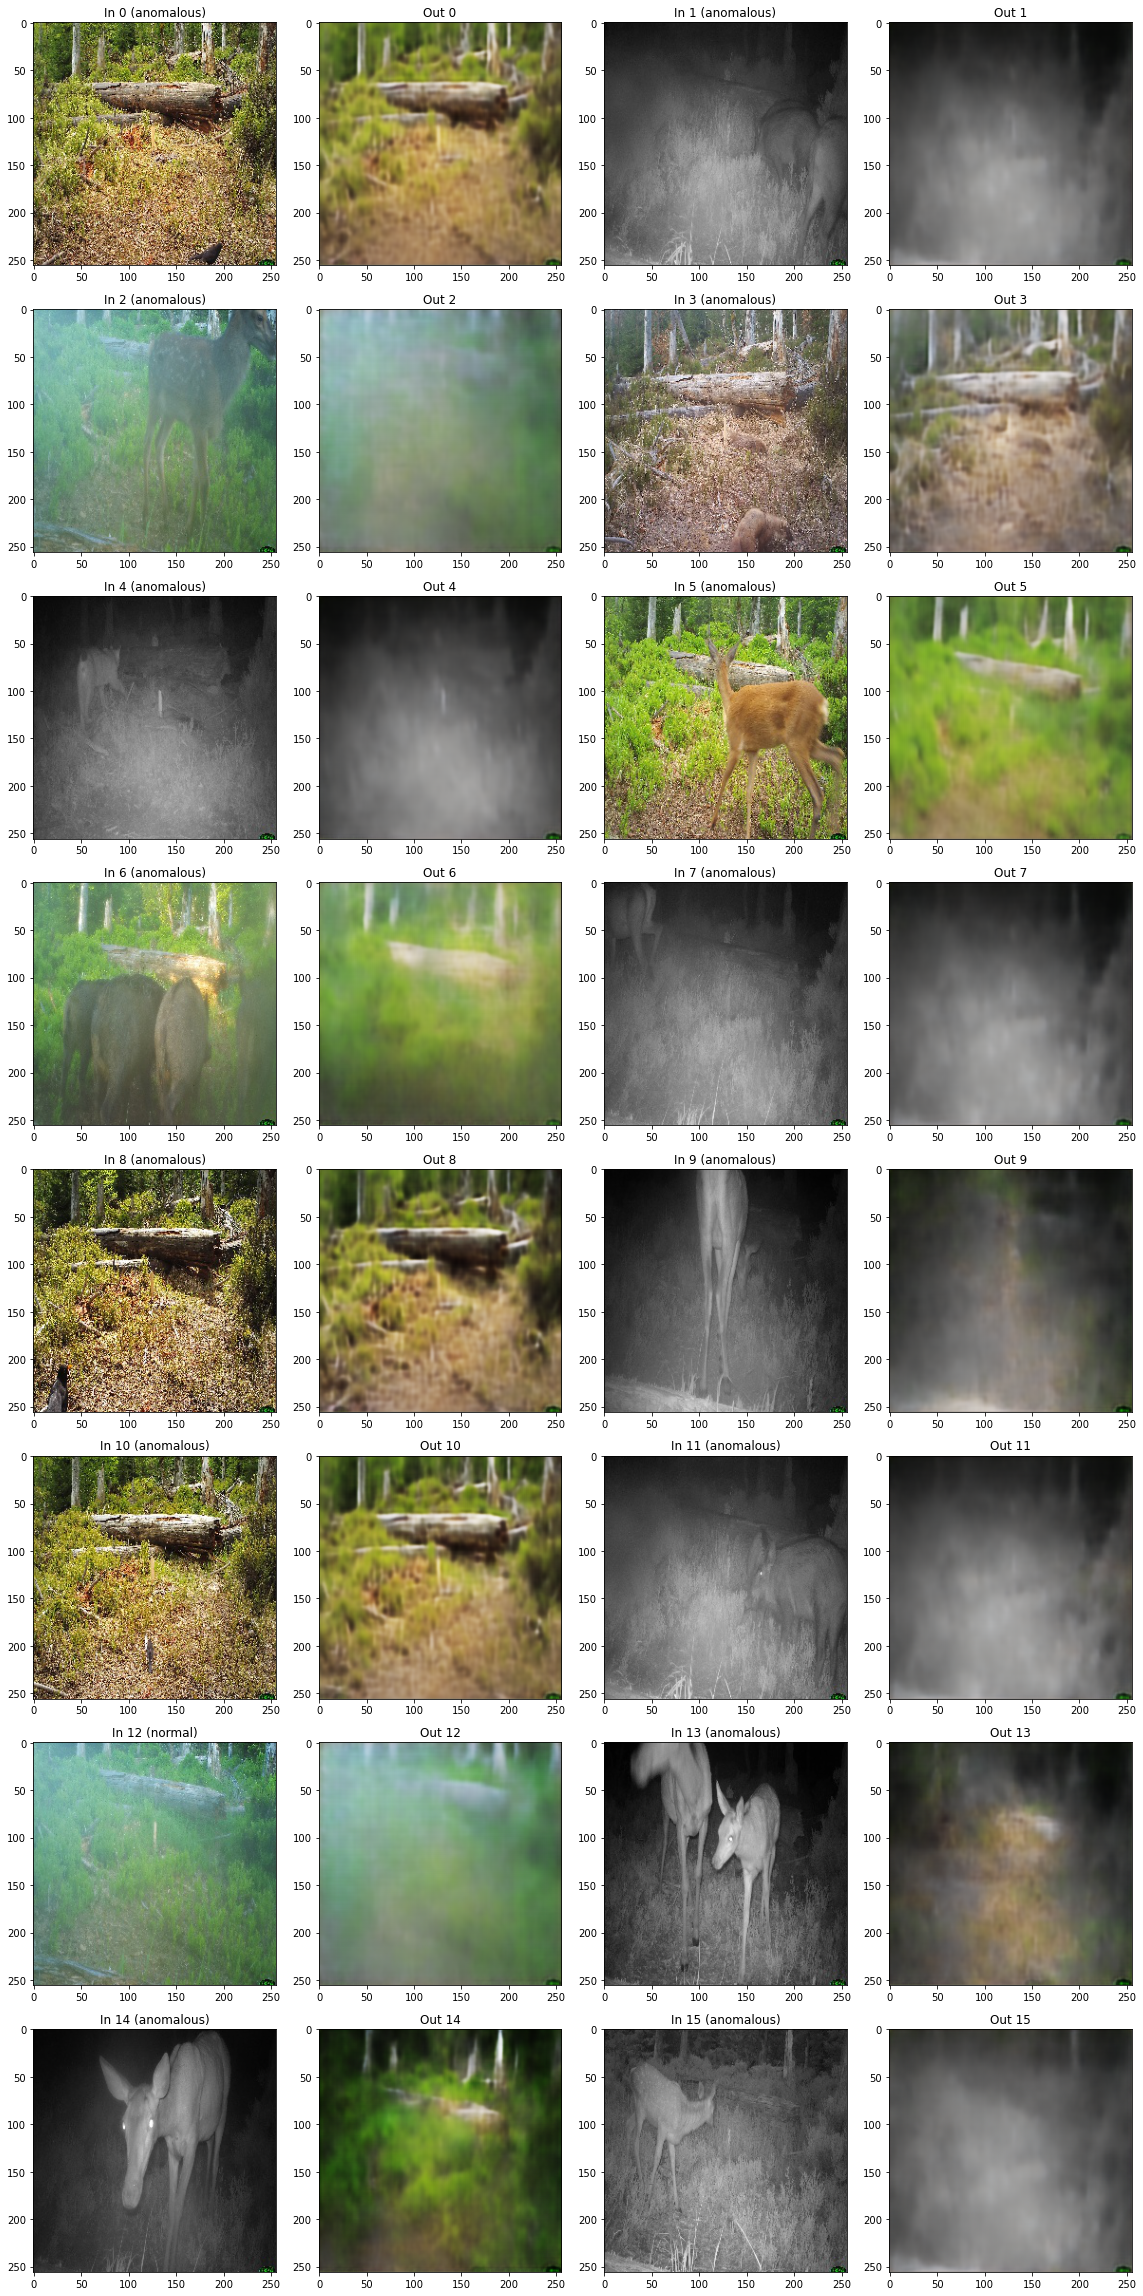

In [9]:
dimgs = []
dlbls = []
only_normals = False
for i in range(32 if only_normals else 16):
    if only_normals and labels[i] == 1:
        continue
    lbl = "anomalous" if labels[i] == 1 else "normal"
    dimgs += [np.einsum("ijk->jki", input_imgs[i]), np.einsum("ijk->jki", output_imgs[i])]
    dlbls += [f"In {i} ({lbl})", f"Out {i}"]
display_images(dimgs, dlbls, size=(4, 4), row_size=4)

In [127]:
lapse_losses, lapse_encodings, lapse_labels = load(f"./ae_train_NoBackup/{TRAIN_NAME}/eval/{session.name}_lapse.pickle")
motion_losses, motion_encodings, motion_labels = load(f"./ae_train_NoBackup/{TRAIN_NAME}/eval/{session.name}_motion.pickle")

In [128]:
kde = KernelDensity(kernel="gaussian", bandwidth=0.01).fit(lapse_encodings)

In [129]:
preds = kde.score_samples(motion_encodings)
y_anom = preds[motion_labels == 1]
y_norm = preds[motion_labels == 0]

In [130]:
pd.Series(y_norm).describe()

count    7.400000e+01
mean    -1.048017e+07
std      2.071084e+07
min     -1.017910e+08
25%     -7.436353e+06
50%     -2.247392e+06
75%     -1.135620e+06
max      1.849936e+03
dtype: float64

In [131]:
pd.Series(y_anom).describe()

count    6.210000e+02
mean    -7.132370e+07
std      1.103709e+08
min     -7.158724e+08
25%     -6.332533e+07
50%     -2.771721e+07
75%     -1.034139e+07
max      1.852779e+03
dtype: float64

In [132]:
mode = "kde"

if mode == "kde":
    y_anom = preds[motion_labels == 1]
    y_norm = preds[motion_labels == 0]
    X = -np.concatenate([y_norm, y_anom]).reshape((-1, 1))
    y = np.concatenate([-np.ones_like(y_norm), np.ones_like(y_anom)])
elif mode == "loss":
    y_anom = motion_losses[motion_labels == 1]
    y_norm = motion_losses[motion_labels == 0]
    X = np.concatenate([y_norm, y_anom]).reshape((-1, 1))
    y = np.concatenate([-np.ones_like(y_norm), np.ones_like(y_anom)])
elif mode in ["kde,loss", "loss,kde"]:
    mode = "kde,loss"
    # generate training data for one-class SVM
    lapse_preds = kde.score_samples(lapse_encodings)
    X_train = np.array([[x1, x2] for x1, x2 in zip(lapse_preds, lapse_losses)])
    X_test = np.array([[x1, x2] for x1, x2 in zip(preds, motion_losses)])
    # train one-class SVM
    clf = OneClassSVM().fit(X_train)
    X = clf.decision_function(X_test).reshape((-1, 1)) # values for thresholding
    y = np.where(motion_labels == 1, 1, -1)
else:
    raise ValueError("unknown mode")


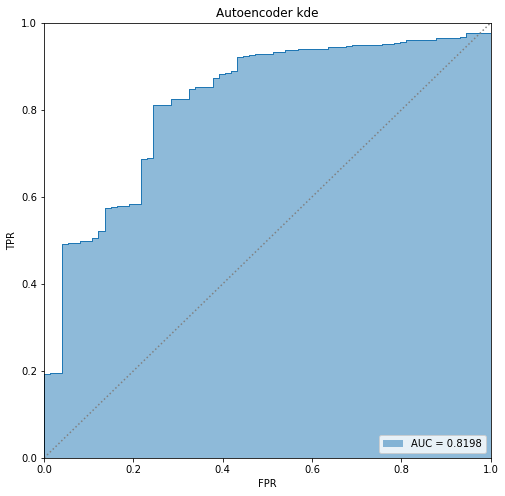

0.9 percentile : TPR = 0.9227, FPR = 0.4324 <-> TNR = 0.5676 @ thresh 2931684.6495045642
0.95 percentile : TPR = 0.9501, FPR = 0.7432 <-> TNR = 0.2568 @ thresh 1145874.4191550955
0.98 percentile : TPR = 0.9823, FPR = 1.0000 <-> TNR = 0.0000 @ thresh -1850.6103394474567
0.99 percentile : TPR = 0.9919, FPR = 1.0000 <-> TNR = 0.0000 @ thresh -1851.015804555487


In [133]:
fpr, tpr, thresholds, auc_score = plot_roc_curve(y, X[:,0], f"Autoencoder {mode}", savefile=f"plots/approach4/roc_curves/{TRAIN_NAME}_{session.name}_{mode}")
get_percentiles(fpr, tpr, thresholds)

## AUC Scores

### Beaver_01

| Mode | AUC |
| --- | ---: |
| Loss | 0.5549 |
| KDE | 0.9209 |
| KDE + Loss | 0.9209 |

### Marten_01

| Mode | AUC |
| --- | ---: |
| Loss | 0.8499 |
| KDE | 1.0 |
| KDE + Loss | 1.0 |

## View most difficult Motion images

In [104]:
lapse_losses, lapse_encodings, lapse_labels = load(f"./ae_train_NoBackup/{TRAIN_NAME}/eval/{session.name}_lapse.pickle")
motion_losses, motion_encodings, motion_labels, images = load(f"./ae_train_NoBackup/{TRAIN_NAME}/eval/{session.name}_motion_withimgs.pickle")

In [105]:
kde = KernelDensity(kernel="gaussian", bandwidth=0.4).fit(lapse_encodings)

### Difficult anomalies

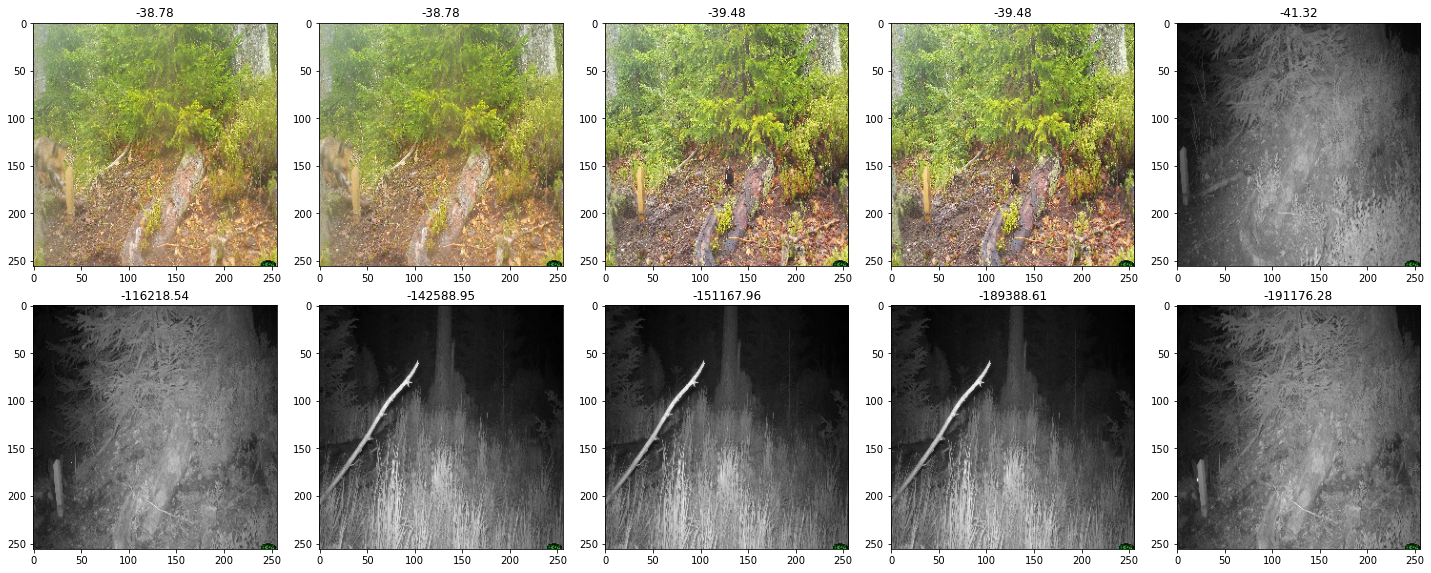

In [106]:
anomalous_encodings = motion_encodings[motion_labels == 1]
anomalous_images = images[motion_labels == 1]
anomalous_preds = kde.score_samples(anomalous_encodings)
difficult_idx = np.argsort(anomalous_preds)[::-1][:10]
difficult_imgs = 0.5 * np.einsum("ijkl->iklj", anomalous_images[difficult_idx]) + 0.5
difficult_probs = anomalous_preds[difficult_idx]
display_images(difficult_imgs, [f"{p:.2f}" for p in difficult_probs], row_size=5, size=(4, 4))

### Easy anomalies

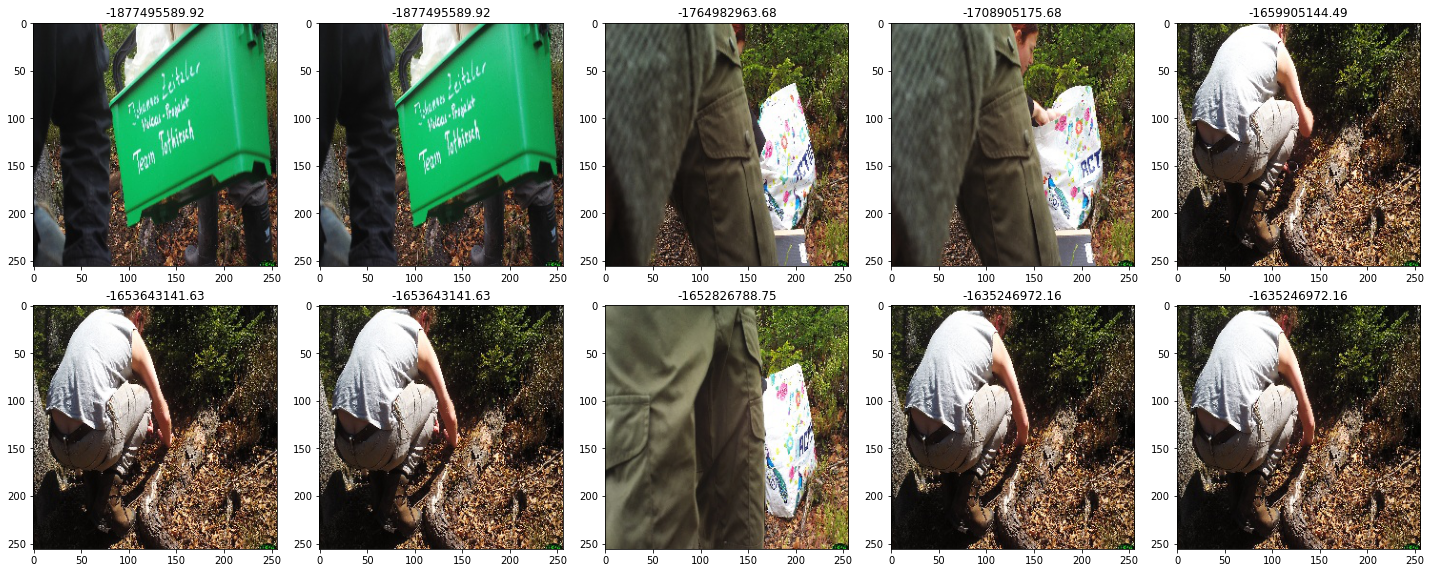

In [107]:
easy_idx = np.argsort(anomalous_preds)[:10]
easy_imgs = 0.5 * np.einsum("ijkl->iklj", anomalous_images[easy_idx]) + 0.5
easy_probs = anomalous_preds[easy_idx]
display_images(easy_imgs, [f"{p:.2f}" for p in easy_probs], row_size=5, size=(4, 4))

### Difficult normals

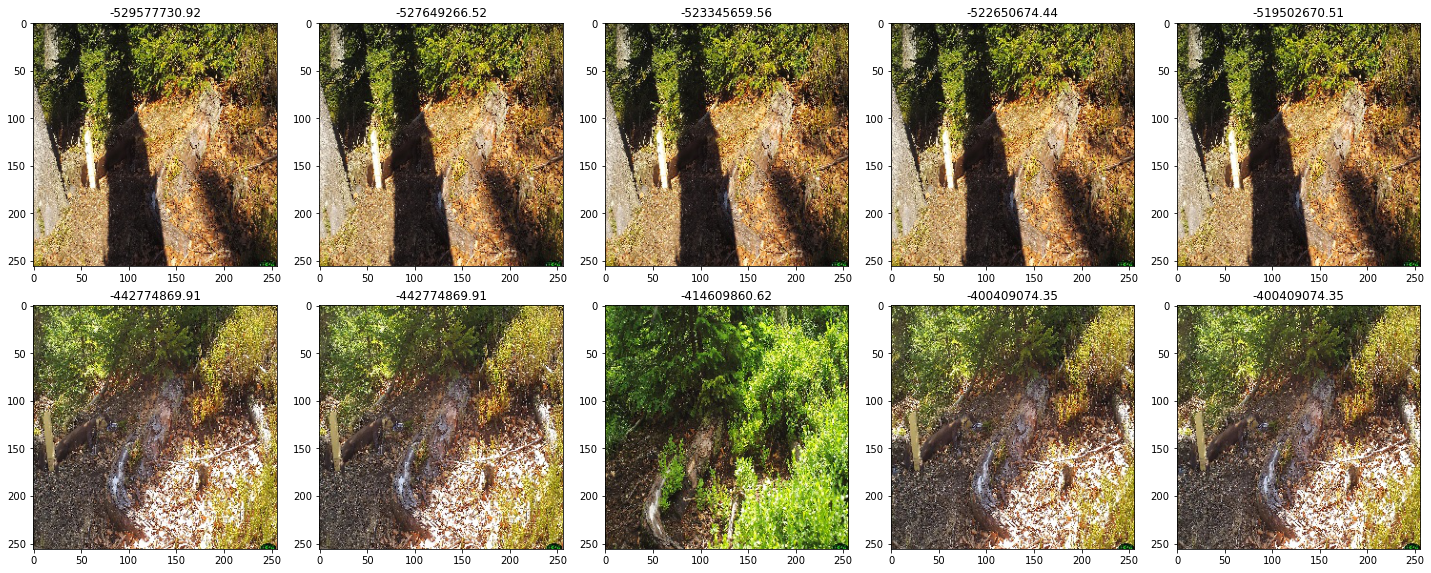

In [108]:
normal_encodings = motion_encodings[motion_labels != 1]
normal_images = images[motion_labels != 1]
normal_preds = kde.score_samples(normal_encodings)
difficult_idx = np.argsort(normal_preds)[:10]
difficult_imgs = 0.5 * np.einsum("ijkl->iklj", normal_images[difficult_idx]) + 0.5
difficult_probs = normal_preds[difficult_idx]
display_images(difficult_imgs, [f"{p:.2f}" for p in difficult_probs], row_size=5, size=(4, 4))

### Easy normals

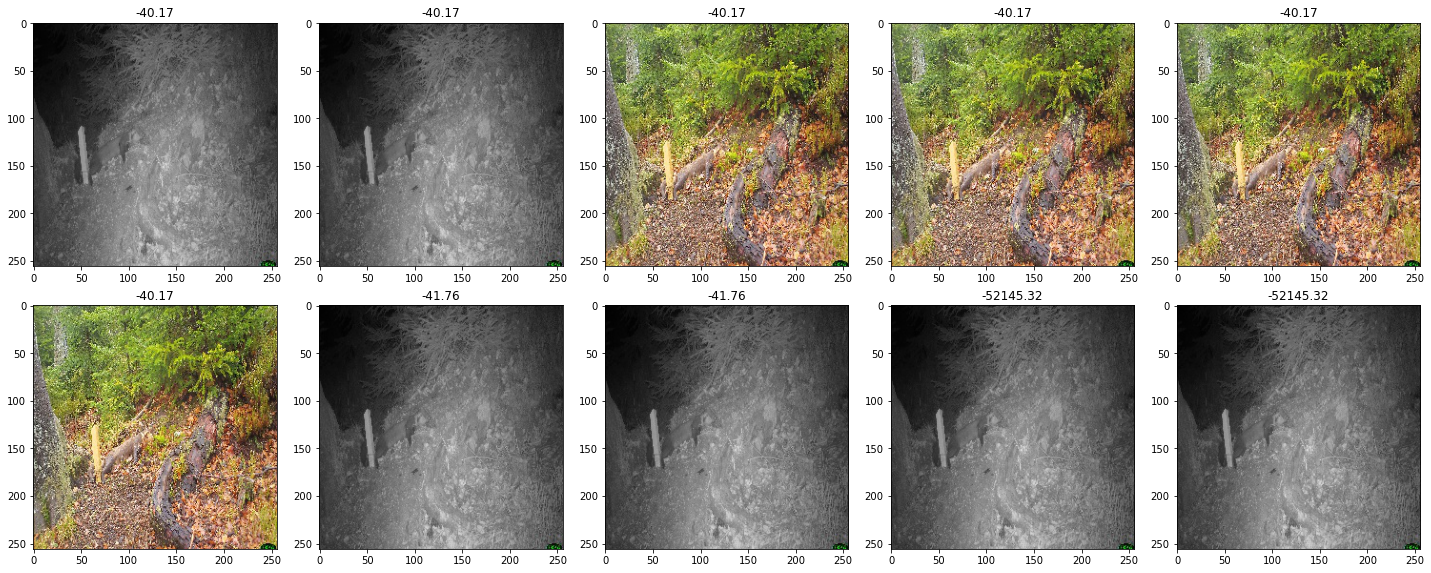

In [109]:
easy_idx = np.argsort(normal_preds)[::-1][:10]
easy_imgs = 0.5 * np.einsum("ijkl->iklj", normal_images[easy_idx]) + 0.5
easy_probs = normal_preds[easy_idx]
display_images(easy_imgs, [f"{p:.2f}" for p in easy_probs], row_size=5, size=(4, 4))